In [ ]:
## -- Required packages --:
import time
import statistics
from numpy import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sklearn as sk
import scipy
from scipy.stats import genextreme as gev
import math
import statistics
from numpy import random
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Lambda, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

In [ ]:
## Package required to read the Red Sea Data
!pip install pyreadr
import pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.0/416.0 kB 11.2 MB/s eta 0:00:00


In [ ]:
def abline(slope, intercept):
    """
    Function to add a straight line to the existing plot
    Arguments:
    * slope
    * intercept
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = 'magenta')

In [ ]:
## -- Link with my google drive to call the dataset --:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Non-Gaussian***

###***Rep 30***

## ***Training Set***

In [ ]:
Parameter_read_NGP = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Trained-Net/ParameterConfiguration-Jan17-Train-Rep30.RData')


Parameter_read_NGP = np.array(Parameter_read_NGP['storeParameterRep'])
print('Dimension of the Parameter_data', Parameter_read_NGP.shape)

Dimension of the Parameter_data (50000, 3)


In [ ]:
Parameter_data_NGP = np.array(Parameter_read_NGP)

shape_vals_NGP = (Parameter_data_NGP[:,0])
awght_vals_NGP = np.log(Parameter_data_NGP[:,1]-4)
lambda_vals_NGP = np.log(Parameter_data_NGP[:,2])

In [ ]:
mean_shape = np.mean(shape_vals_NGP)
mean_awght = np.mean(awght_vals_NGP)
mean_lambda = np.mean(lambda_vals_NGP)

sd_shape = np.std(shape_vals_NGP)
sd_awght = np.std(awght_vals_NGP)
sd_lambda = np.std(lambda_vals_NGP)

In [ ]:
Y_train_NGP = np.transpose(((shape_vals_NGP-mean_shape)/sd_shape, (awght_vals_NGP - mean_awght)/sd_awght, (lambda_vals_NGP - mean_lambda)/sd_lambda))
print(Y_train_NGP.shape)

(50000, 3)


In [ ]:
print('Shape of Parameter_data_NGP:', Y_train_NGP.shape)

Shape of Parameter_data_NGP: (50000, 3)


In [ ]:
shape_train_NGPCS = pd.DataFrame(shape_vals_NGP)
shape_train_NGPCS.describe()

,0
count,50000.000000
mean,0.457179
std,0.256520
min,0.010009
25%,0.235989
50%,0.457663
75%,0.680780
max,0.899984


In [ ]:
kappa2_train_NGPCS = pd.DataFrame(np.exp(awght_vals_NGP)+4)
kappa2_train_NGPCS.describe()

,0
count,50000.000000
mean,4.263058
std,0.439510
min,4.001001
25%,4.006508
50%,4.044366
75%,4.303847
max,5.999882


In [ ]:
tau2_train_NGPCS = pd.DataFrame(np.exp(lambda_vals_NGP))
tau2_train_NGPCS.describe()

,0
count,50000.000000
mean,0.010820
std,0.020536
min,0.000010
25%,0.000101
50%,0.000993
75%,0.010115
max,0.099991


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Trained-Net/storeZRep-Jan17-Train-Rep30.RData'
# storeZRep-Jan14-Train-Rep30-Latest.RData'


r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'storeZRep' in the R environment
if 'storeZRep' in r_objects:
    my_3d_array = r['storeZRep']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "storeZRep"

Shape of the array: (50000, 256, 30)


In [ ]:
Z_train_NGP = numpy_3d_array # dimension: 5000, 256, 30
np.shape(Z_train_NGP)

(50000, 256, 30)

In [ ]:
# Assuming numpy_3d_array is already defined
from scipy.stats import iqr
Z_train_NGP_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
    if i % 1000 == 0:  # Correct modulus operator
        print(i)
    for j in range(numpy_3d_array.shape[2]):
        # Compute median and IQR
        slice_mean = np.median(numpy_3d_array[i, :, j])

        # Compute Q1 (25th percentile) and Q3 (75th percentile)
        q1 = np.percentile(numpy_3d_array[i, :, j], 25)
        q3 = np.percentile(numpy_3d_array[i, :, j], 75)

        # Compute IQR
        slice_std  = np.std(numpy_3d_array[i, :, j])
        #iqr(numpy_3d_array[i, :, j]) # changed from np.std()


        # Standardize or set to 0 if std is zero
        if slice_std != 0:
            Z_train_NGP_std[i, :, j] = (numpy_3d_array[i, :, j] - slice_mean)/slice_std
        else:
            Z_train_NGP_std[i, :, j] = 0

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [ ]:
Z_train_NGP_std.shape

(50000, 256, 30)

In [ ]:
Z_train_NGP_std.shape[0]

50000

In [ ]:
Z_train_reshaped_NGP = Z_train_NGP_std.reshape(Z_train_NGP_std.shape[0], 16, 16, 30)
## Z_train_reshaped_NGP = Z_train_NGP.reshape(Z_train_NGP.shape[0], 16, 16, 30)
print('Shape of Z_train_reshaped:', Z_train_reshaped_NGP.shape)

Shape of Z_train_reshaped: (50000, 16, 16, 30)


In [ ]:
Z_train_NGP = Z_train_reshaped_NGP
Z_train_NGP.shape

(50000, 16, 16, 30)

In [ ]:
np.min(Z_train_NGP)

-6.151241570707157

In [ ]:
np.max(Z_train_NGP)

7903.644784304124

In [ ]:
from sklearn.model_selection import train_test_split
x_train_NGP, x_valid_NGP, y_train_NGP, y_valid_NGP = train_test_split(Z_train_NGP, Y_train_NGP, test_size=0.20, shuffle= True)

In [ ]:
#del modelRep30
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

# Define the input
input_shape = (16, 16, 30)
inputs = Input(shape=input_shape)

# First Convolutional Block
x = Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer=HeNormal())(inputs) # changed from (5,5) # changed from 32 to 64 # , kernel_regularizer=l2(0.001)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Second Convolutional Block
x = Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer=HeNormal())(x) # changed from (3,3) # changed from 64 to 128 # , kernel_regularizer=l2(0.001)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x = Dense(units=512, activation="relu", kernel_initializer=HeNormal())(x) # changed from 512
x = Dense(units=10, activation="linear", kernel_initializer=HeNormal())(x)

# Output Layer
output_layer = Dense(units=3, activation="linear")(x)

# Create the model
modelRep30 = Model(inputs=inputs, outputs=output_layer)
modelRep30.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16, 16, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,251 (227.54 KB)

 Trainable params: 58,059 (226.79 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Already trained
n_epoch = 100
batch_size = 100 # changed from 128 or 32 ## latest changed 200


train_dataset = tf.data.Dataset.from_tensor_slices((x_train_NGP, y_train_NGP)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid_NGP, y_valid_NGP)).batch(batch_size)


# Compile the model
modelRep30.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss=tf.losses.MeanAbsoluteError(),
                   metrics=[tf.losses.MeanSquaredError()]) # Absolute

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               mode='min',
                               restore_best_weights=True)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=3,
                                         mode='min')

# Training the CNN model
start_time= time.time()

# Assuming train_dataset and valid_dataset are your training and validation data
history = modelRep30.fit(train_dataset,
                         validation_data=valid_dataset,
                         epochs=n_epoch,
                         batch_size=batch_size,
                         callbacks=[reduce_lr_on_plateau])

print("--- %s seconds ---" % (time.time()-start_time))
time_train = (time.time()-start_time)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.5158 - mean_squared_error: 0.4545 - val_loss: 0.4581 - val_mean_squared_error: 0.3642 - learning_rate: 0.0010
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.3219 - mean_squared_error: 0.1902 - val_loss: 0.4031 - val_mean_squared_error: 0.2970 - learning_rate: 0.0010
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.2797 - mean_squared_error: 0.1503 - val_loss: 0.3506 - val_mean_squared_error: 0.2315 - learning_rate: 0.0010
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.2570 - mean_squared_error: 0.1295 - val_loss: 0.3166 - val_mean_squared_error: 0.1988 - learning_rate: 0.0010
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.2445 - mean_squared_error: 0.1186 - val_loss: 0.2906 - val_mean_squared_error: 0.1738 - learning_rate: 0.0010
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.2336 - mean_squared_error: 0.1097 - val_loss: 0.2852 - val_m

In [ ]:
## Already trained
# n_epoch = 100
# batch_size = 100 # changed from 128 or 32 ## latest changed 200


# train_dataset = tf.data.Dataset.from_tensor_slices((x_train_NGP, y_train_NGP)).batch(batch_size)
# valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid_NGP, y_valid_NGP)).batch(batch_size)


# # Compile the model
# modelRep30.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#                    loss=tf.losses.MeanAbsoluteError(),
#                    metrics=[tf.losses.MeanSquaredError()]) # Absolute

# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss',
#                                patience=6,
#                                mode='min',
#                                restore_best_weights=True)

# reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',
#                                          factor=0.1,
#                                          patience=3,
#                                          mode='min')

# # Training the CNN model
# start_time= time.time()

# # Assuming train_dataset and valid_dataset are your training and validation data
# history = modelRep30.fit(train_dataset,
#                          validation_data=valid_dataset,
#                          epochs=n_epoch,
#                          batch_size=batch_size,
#                          callbacks=[reduce_lr_on_plateau])

# print("--- %s seconds ---" % (time.time()-start_time))
# time_train = (time.time()-start_time)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.4899 - mean_squared_error: 0.4269 - val_loss: 0.3995 - val_mean_squared_error: 0.2923 - learning_rate: 0.0010
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2969 - mean_squared_error: 0.1653 - val_loss: 0.2764 - val_mean_squared_error: 0.1506 - learning_rate: 0.0010
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2615 - mean_squared_error: 0.1353 - val_loss: 0.2369 - val_mean_squared_error: 0.1168 - learning_rate: 0.0010
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.2405 - mean_squared_error: 0.1177 - val_loss: 0.2337 - val_mean_squared_error: 0.1178 - learning_rate: 0.0010
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2275 - mean_squared_error: 0.1065 - val_loss: 0.2270 - val_mean_squared_error: 0.1102 - learning_rate: 0.0010
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.2187 - mean_squared_error: 0.0992 - val_loss: 0.2208 - val_m

In [ ]:
time_train/60

19.470965099334716

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print(f"Training loss on the final epoch was: {history.history['loss'][-1]:0.4f}")
plt.show()

NameError: name 'history' is not defined

In [ ]:
## Save the model - Latest updated Jan 8, 2025
# modelRep30.save('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/CNN-ModelRep30-Jan17-2025.keras')

In [ ]:
import tensorflow as tf

# Load the model from the .keras file
modelRep30 = tf.keras.models.load_model('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Trained-Net/CNN-ModelRep30-Jan17-2025.keras')


print("Model loaded successfully.")

# Optionally, print the model summary to confirm it loaded correctly
modelRep30.summary()

Model loaded successfully.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 16, 16, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,371 (681.14 KB)

 Trainable params: 58,059 (226.79 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 116,120 (453.60 KB)

In [ ]:
train_estimates_NGP = modelRep30.predict(Z_train_NGP)

# loaded_model
train_estimates_NGP = np.array(train_estimates_NGP)

NameError: name 'Z_train_NGP' is not defined

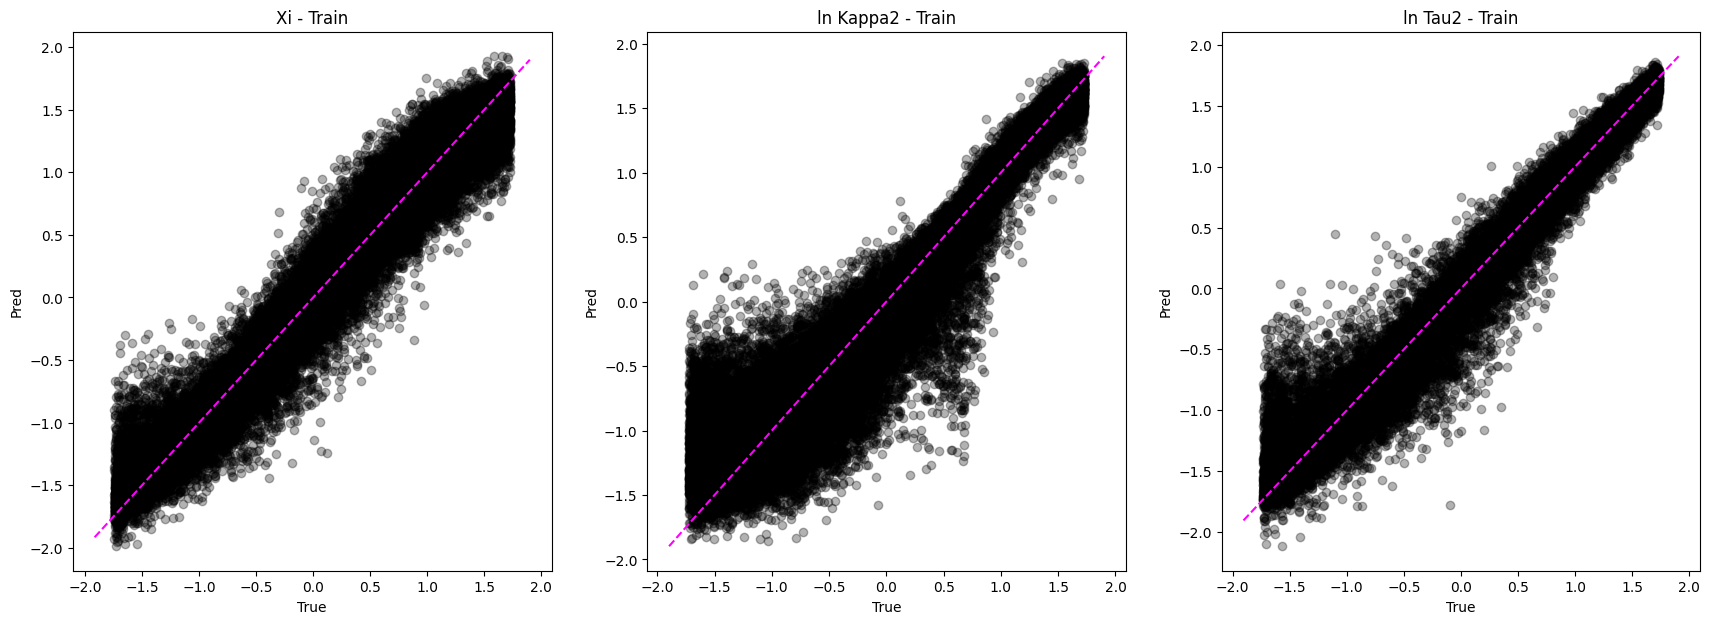

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_train_NGP[:,0],
            train_estimates_NGP[:,0],
            color='black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_train_NGP[:,1]),
            (train_estimates_NGP[:,1]),
            color='black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_train_NGP[:,2]),
            (train_estimates_NGP[:,2]),
            color='black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

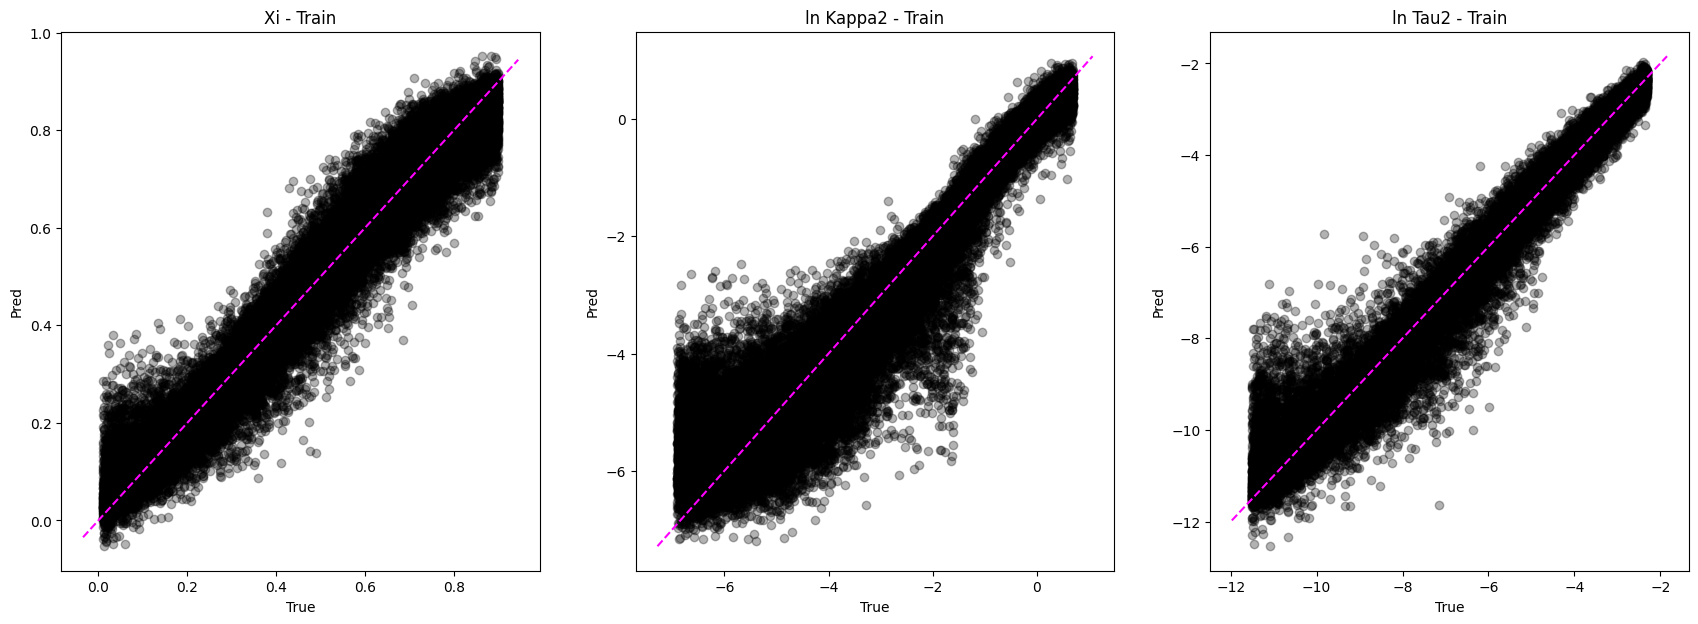

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_train_NGP[:,0]*sd_shape + mean_shape,
            train_estimates_NGP[:,0]*sd_shape + mean_shape,
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_train_NGP[:,1]*sd_awght + mean_awght),
            (train_estimates_NGP[:,1]*sd_awght + mean_awght),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_train_NGP[:,2]*sd_lambda + mean_lambda),
            (train_estimates_NGP[:,2]*sd_lambda + mean_lambda),
            color = 'black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

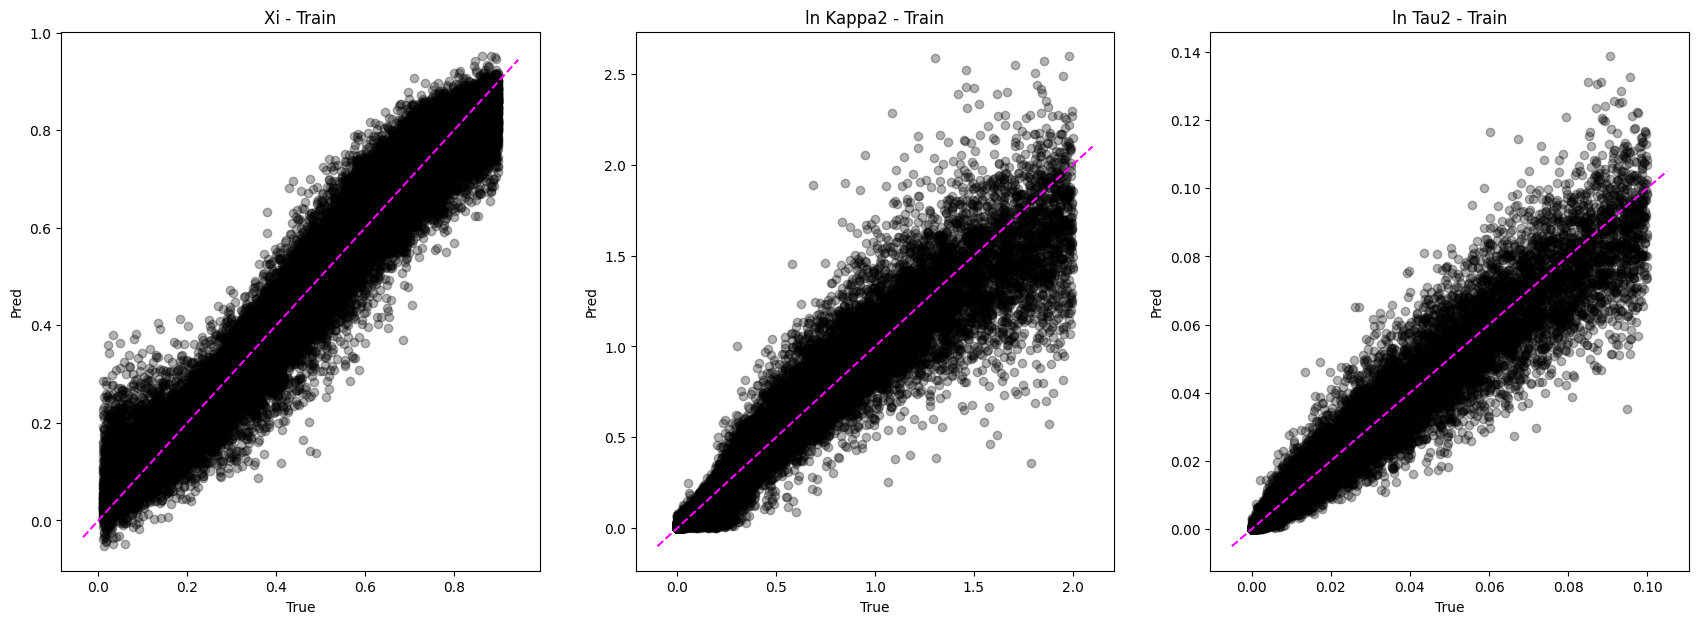

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_train_NGP[:,0]*sd_shape + mean_shape,
            train_estimates_NGP[:,0]*sd_shape + mean_shape,
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter(np.exp(Y_train_NGP[:,1]*sd_awght + mean_awght),
            np.exp(train_estimates_NGP[:,1]*sd_awght + mean_awght),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(np.exp(Y_train_NGP[:,2]*sd_lambda + mean_lambda),
            np.exp(train_estimates_NGP[:,2]*sd_lambda + mean_lambda),
            color = 'black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [ ]:
shape_est_train = train_estimates_NGP[:,0]*sd_shape + mean_shape
awght_est_train =  (train_estimates_NGP[:,1]*sd_awght + mean_awght)
lambda_est_train = (train_estimates_NGP[:,2]*sd_lambda + mean_lambda)

y_est_train = np.transpose((shape_est_train , awght_est_train, lambda_est_train))
print(y_est_train.shape)

(50000, 3)


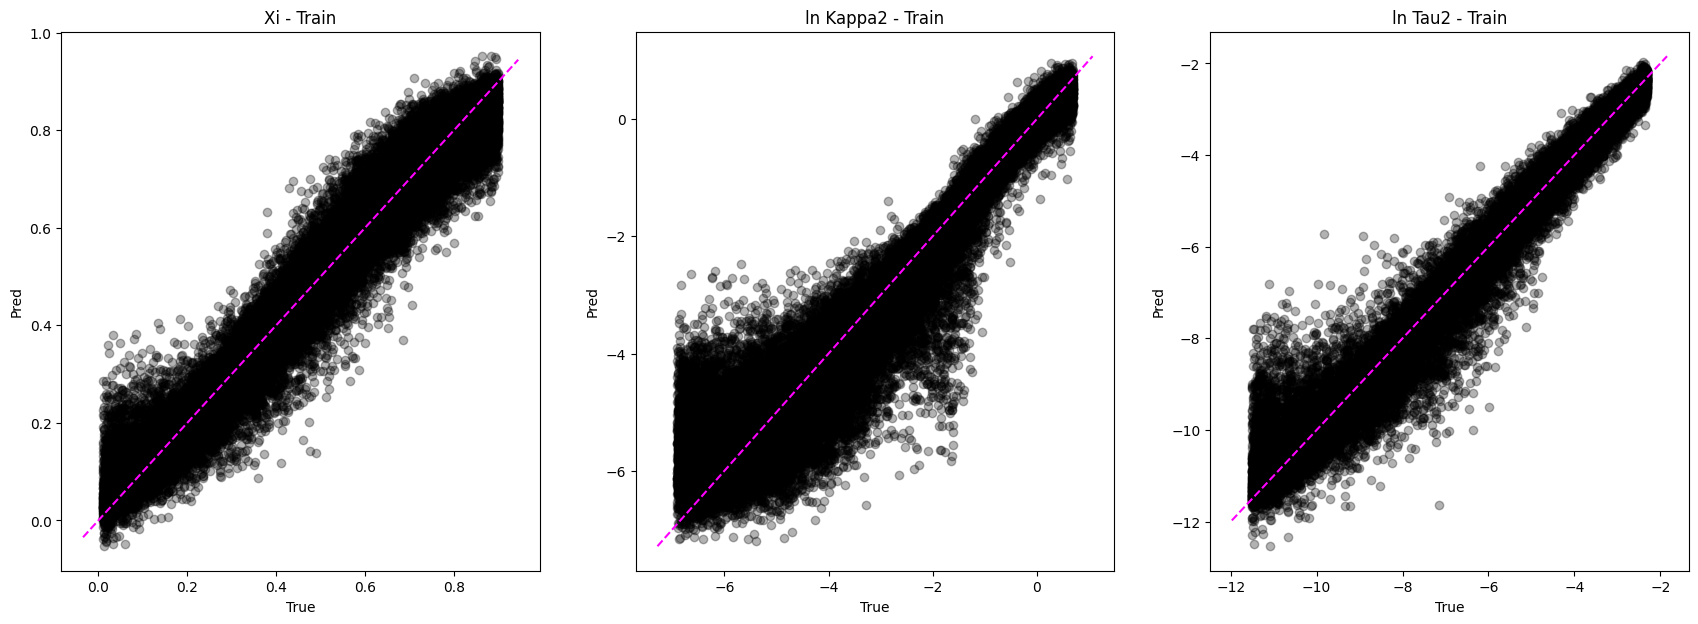

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_train_NGP[:,0]*sd_shape + mean_shape,
            y_est_train[:,0],
            color = 'black',
            alpha=0.3)
plt.title('Xi - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_train_NGP[:,1]*sd_awght + mean_awght),
            y_est_train[:,1],
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(Y_train_NGP[:,2]*sd_lambda + mean_lambda,
            y_est_train[:,2],
            color = 'black',
            alpha=0.3)
plt.title('ln Tau2 - Train')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [ ]:
# Save the array to a .npy file
np.save('trainEstimates-n-30-Latest-Jan17-2025.npy', y_est_train)

# ***Test Set***

### ***RCM Data Set***

In [ ]:
### ***NOT REQUIRED***
### -- To save the storeSample matrix in google drive --:
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17
np.savetxt("RCMestimates.csv", RCMestimates, delimiter=",")

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Activate automatic conversion for R <-> Python objects
pandas2ri.activate()

# Load the RData file
rdata_file = "SCL-RCMannualMax.RData"
ro.r['load'](rdata_file)  # Load the file into R's environment

# Get the R objects
r_objects = ro.r
r_object_names = r_objects.ls()  # List all objects in the R environment

print(f"R objects loaded: {r_object_names}")

# Access a specific object (replace 'object_name' with the actual name in your RData file)
object_name = r_object_names[0]  # Assuming the first object is of interest
r_object = r_objects[object_name]

# If it's a data frame, convert it to a pandas DataFrame
with localconverter(ro.default_converter + pandas2ri.converter):
    df = ro.conversion.rpy2py(r_object)

print(df.shape)

RRuntimeError: Error in readChar(con, 5L, useBytes = TRUE) : cannot open the connection


In [ ]:
RCMestimates = model.predict(df)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [ ]:
np.savetxt("testEstSampleSize30-NoRep-NoLambda.csv", test_estimates_NGP, delimiter=",")

In [ ]:
np.savetxt("testParameterEstSampleSize30-NoRep.csv", test_estimates_NGP, delimiter=",")
np.savetxt("trueParameterEstSampleSize30-NoRep.csv", Parameter_read_NGP_test, delimiter=",")

#  ***Latest Test Sample***

In [ ]:
# # Save the array to a .npy file
# np.save('test_estimates_NGP-n-30-Latest-Jan08-2025.npy', test_estimates_NGP_UQ)

In [ ]:
## Defining test set - Latest Jan 8, 2025
Parameter_read_NGP_test = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/ParameterConfiguration-Jan22-Test-Rep30-Latest.RData')

Parameter_read_NGP_test = np.array(Parameter_read_NGP_test['parameterComb']) # changed from storeParameterRep
print('Dimension of the Parameter_data', Parameter_read_NGP_test.shape)

Dimension of the Parameter_data (10000, 3)


In [ ]:
shape_vals_NGP_test = (Parameter_read_NGP_test[:,0])
awght_vals_NGP_test = np.log(Parameter_read_NGP_test[:,1]-4)
lambda_vals_NGP_test = np.log(Parameter_read_NGP_test[:,2])

In [ ]:
Y_test_NGP = np.transpose(((shape_vals_NGP_test - mean_shape)/sd_shape, (awght_vals_NGP_test - mean_awght)/sd_awght, (lambda_vals_NGP_test - mean_lambda)/sd_lambda))
print(Y_test_NGP.shape)

(10000, 3)


In [ ]:
shape_test_NGP = pd.DataFrame(shape_vals_NGP_test)
shape_test_NGP.describe()

,0
count,10000.000000
mean,0.501507
std,0.173524
min,0.200091
25%,0.348936
50%,0.501711
75%,0.651778
max,0.799977


In [ ]:
awght_test_NGP = pd.DataFrame(np.exp(awght_vals_NGP_test))
awght_test_NGP.describe()

,0
count,10000.000000
mean,0.338590
std,0.435316
min,0.010013
25%,0.036009
50%,0.129581
75%,0.483536
max,1.798834


In [ ]:
lambda_test_NGP = pd.DataFrame(np.exp(lambda_vals_NGP_test))
lambda_test_NGP.describe()

,0
count,10000.000000
mean,0.008027
std,0.011740
min,0.000100
25%,0.000476
50%,0.002190
75%,0.010627
max,0.049974


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/storeZRep-Jan22-Test-Rep30-Latest.RData'

# storeZRep-Jan14-Test-Rep30-Latest.RData' # previously used file

r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'storeZRep' in the R environment
if 'extremalFields' in r_objects: # storeZRepScaled
    my_3d_array = r['extremalFields']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "extremalFields" "storeZRep"     

Shape of the array: (10000, 256, 30)


In [ ]:
# Reshape the array to (40200, 16, 16, 10)
Z_test_NGP = numpy_3d_array

In [ ]:
import numpy as np
Z_test_NGP_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
  if i % 1000 == 0:  # Correct modulus operator
        print(i)

  for j in range(numpy_3d_array.shape[2]):
    slice_mean = np.median(numpy_3d_array[i, :, j])
    slice_std = np.std(numpy_3d_array[i, :, j])

    # min = np.min(numpy_3d_array[i, :, j])
    # max = np.max(numpy_3d_array[i, :, j])

    if slice_std != 0:  #
        Z_test_NGP_std[i, :, j] = (numpy_3d_array[i, :, j] - slice_mean)/slice_std
    else:
        Z_test_NGP_std[i, :, j] = 0

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [ ]:
Z_test_reshaped_NGP = Z_test_NGP_std.reshape(Z_test_NGP_std.shape[0], 16, 16, 30) # (Z_test_NGP.shape[0], 100, 16, 16, 30)

# Check the shape of the reshaped array
print('Shape of Z_test_reshaped:', Z_test_reshaped_NGP.shape)

Z_test_NGP = np.array(Z_test_reshaped_NGP)

# Print max and min values for the first sample in the reshaped array
print('Z_test max:', Z_test_NGP [0,:,:].max())
print('Z_test min:', Z_test_NGP [0,:,:].min())

Z_test_NGP.shape

Shape of Z_test_reshaped: (10000, 16, 16, 30)
Z_test max: 11.85537685611519
Z_test min: -1.6147874357701222


(10000, 16, 16, 30)

In [ ]:
test_estimates_NGP = modelRep30.predict(Z_test_NGP)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
np.shape(test_estimates_NGP)

(10000, 3)

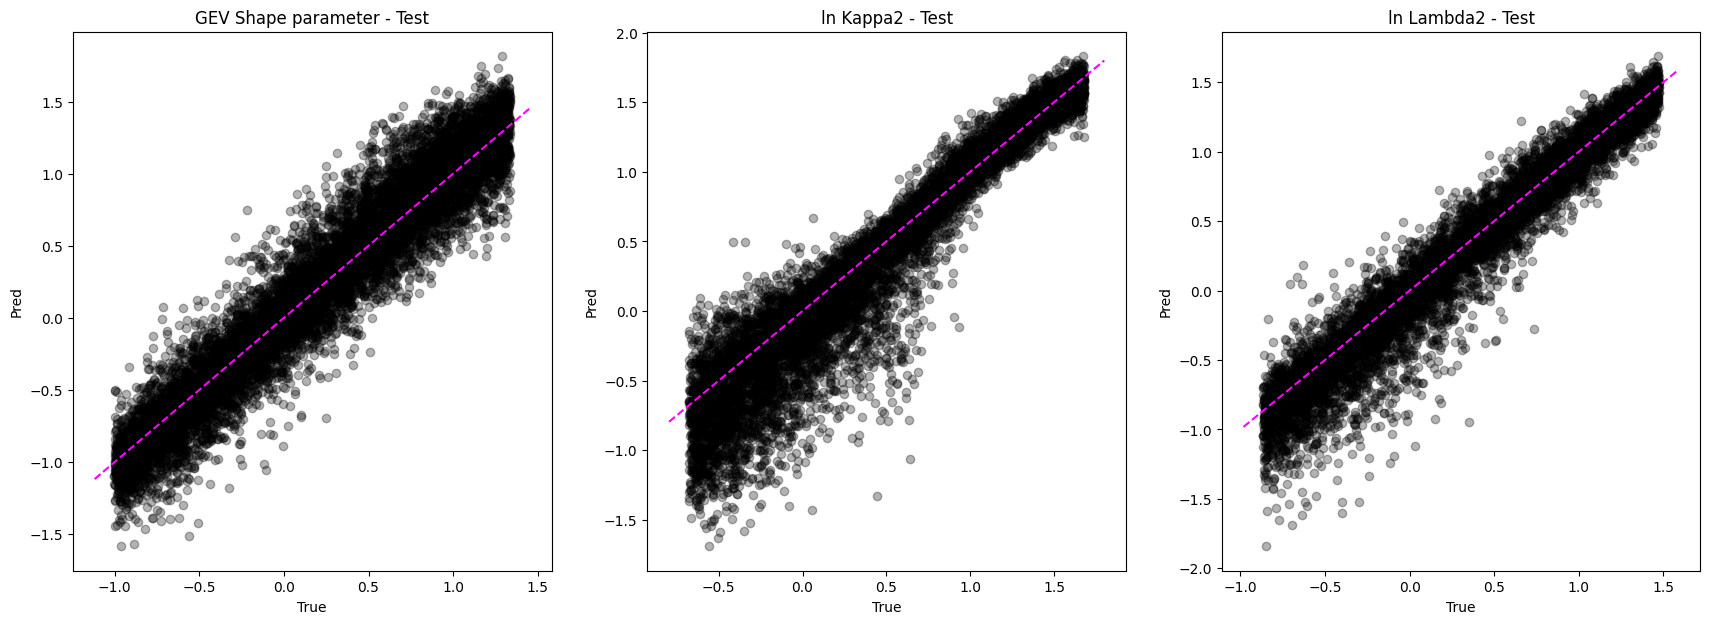

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_NGP[:, 0]),
            (test_estimates_NGP[:, 0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1]),
            (test_estimates_NGP[:,  1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_NGP[:,2]),
            (test_estimates_NGP[:, 2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

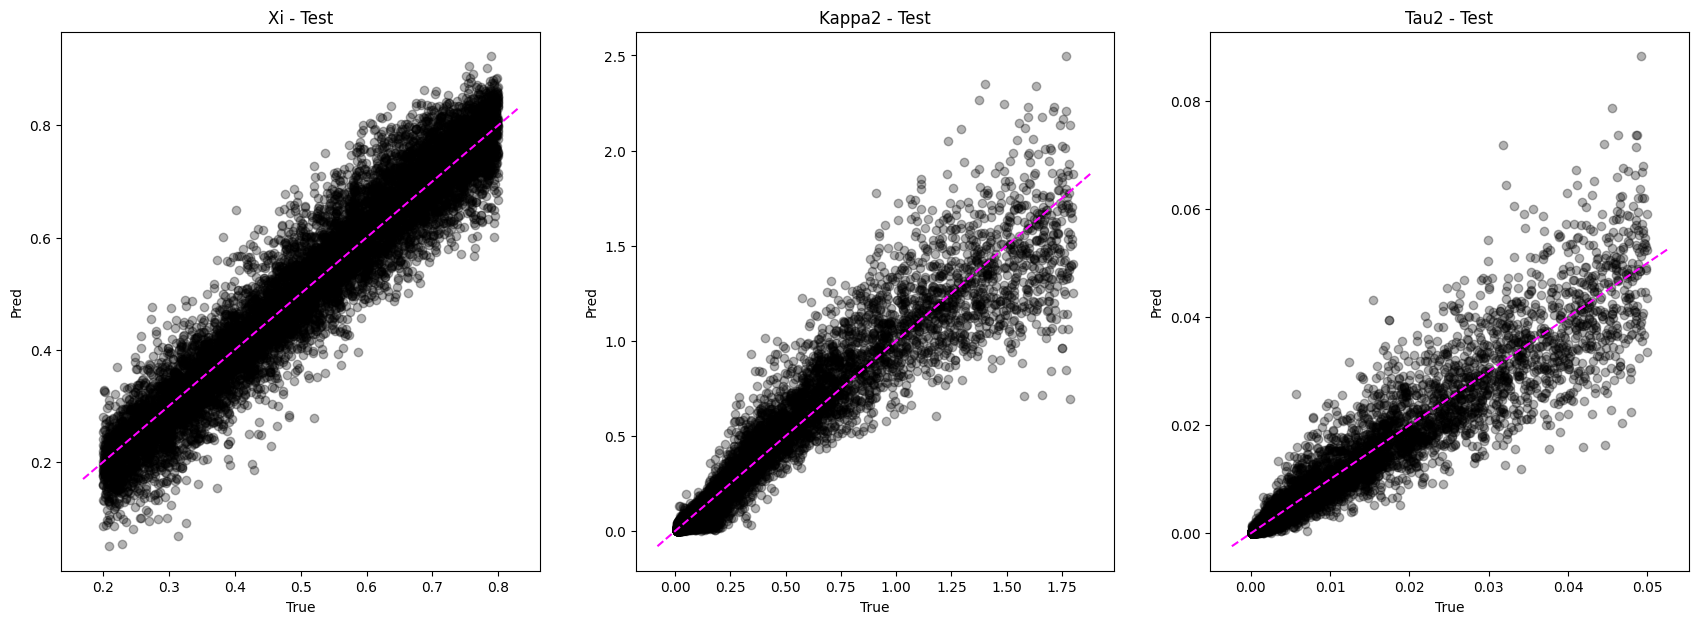

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_test_NGP[:,0]*sd_shape + mean_shape,
            test_estimates_NGP[:,0]*sd_shape + mean_shape,
            color = 'black',
            alpha=0.3)
plt.title('Xi - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter(np.exp(Y_test_NGP[:,1]*sd_awght + mean_awght),
            np.exp(test_estimates_NGP[:,1]*sd_awght + mean_awght),
            color = 'black',
            alpha=0.3)
plt.title('Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
# plt.ylim(-0.08,2.2)
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(np.exp(Y_test_NGP[:,2]*sd_lambda + mean_lambda),
            np.exp(test_estimates_NGP[:,2]*sd_lambda + mean_lambda),
            color = 'black',
            alpha=0.3)
plt.title('Tau2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
# plt.ylim(-0.01,0.124)
abline(1, 0)

plt.show()

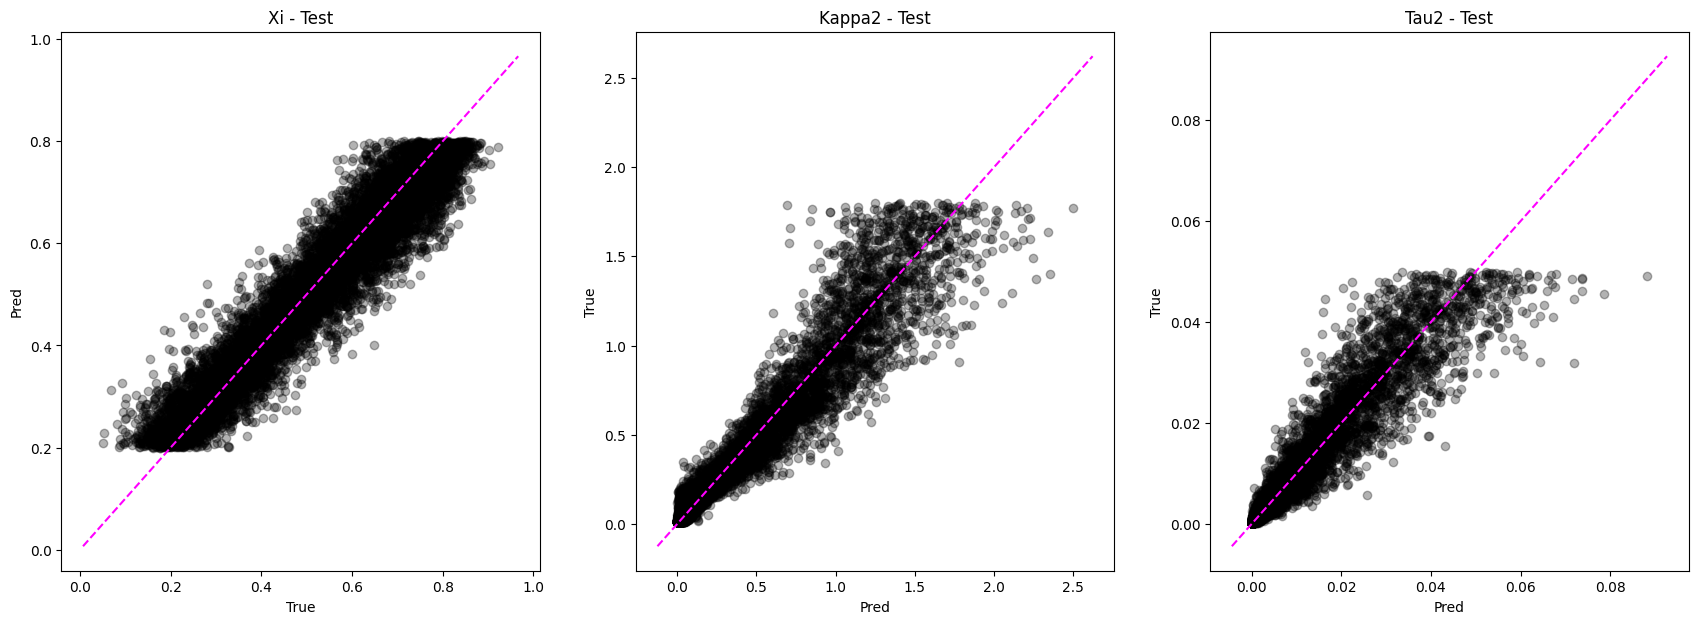

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(test_estimates_NGP[:,0]*sd_shape + mean_shape,
            Y_test_NGP[:,0]*sd_shape + mean_shape,
            color = 'black',
            alpha=0.3)
plt.title('Xi - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter(np.exp(test_estimates_NGP[:,1]*sd_awght + mean_awght),
            np.exp(Y_test_NGP[:,1]*sd_awght + mean_awght),

            color = 'black',
            alpha=0.3)
plt.title('Kappa2 - Test')
plt.xlabel('Pred')
plt.ylabel('True')
# plt.ylim(-0.1,2.2)
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(np.exp(test_estimates_NGP[:,2]*sd_lambda + mean_lambda),
            np.exp(Y_test_NGP[:,2]*sd_lambda + mean_lambda),
            color = 'black',
            alpha=0.3)
plt.title('Tau2 - Test')
plt.xlabel('Pred')
plt.ylabel('True')
#plt.ylim(-0.01,0.124)
abline(1, 0)

plt.show()

In [ ]:
shape_est_test = test_estimates_NGP[:,0]*sd_shape + mean_shape
awght_est_test =  (test_estimates_NGP[:,1]*sd_awght + mean_awght)
lambda_est_test = (test_estimates_NGP[:,2]*sd_lambda + mean_lambda)

y_est_test = np.transpose((shape_est_test , awght_est_test, lambda_est_test))
print(y_est_test.shape)

(10000, 3)


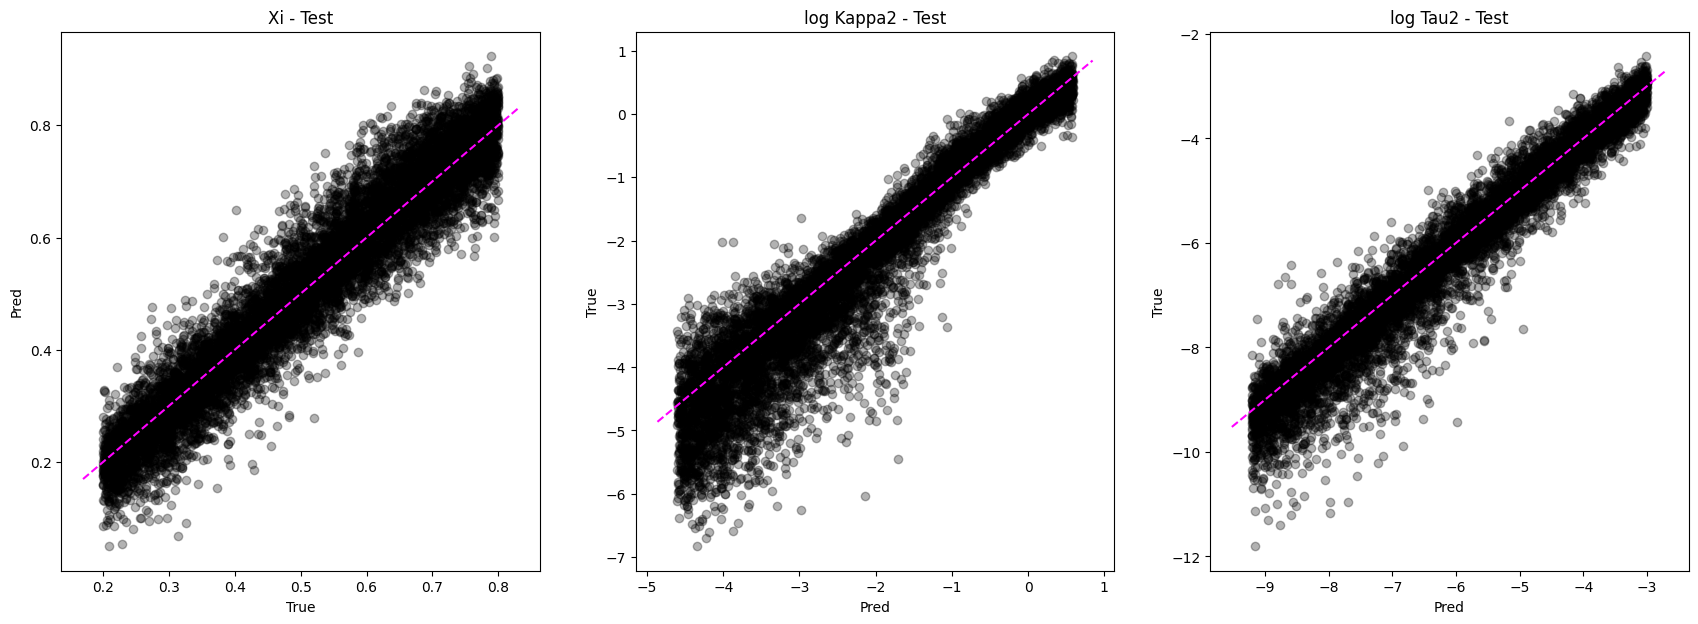

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter(Y_test_NGP[:, 0]*sd_shape + mean_shape,
            y_est_test[:,0],
            color = 'black',
            alpha=0.3)
plt.title('Xi - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter(Y_test_NGP[:, 1]*sd_awght + mean_awght,
            y_est_test[:,1],
            color = 'black',
            alpha=0.3)
plt.title('log Kappa2 - Test')
plt.xlabel('Pred')
plt.ylabel('True')
# plt.ylim(-0.1,2.2)
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(Y_test_NGP[:,2]*sd_lambda + mean_lambda,
            y_est_test[:,2],
            color = 'black',
            alpha=0.3)
plt.title('log Tau2 - Test')
plt.xlabel('Pred')
plt.ylabel('True')
#plt.ylim(-0.01,0.124)
abline(1, 0)

plt.show()

In [ ]:
# Save the array to a .npy file
np.save('test_estimates_NGP-n-30-Latest-Jan22-2025.npy', y_est_test)

In [ ]:
y_est_test.shape

(10000, 3)

In [ ]:
Parameter_read_NGP_test_Rep

OrderedDict([('parameterComb',
                 shapeGrid  AWghtGrid  lambdaGrid
              0   0.508954   4.163987     0.00001
              1   0.426598   4.359812     0.00001
              2   0.451002   4.044247     0.00001)])

##  ***Test set with replication***

In [ ]:
## Defining test set - Latest Jan 8, 2025
Parameter_read_NGP_test_Rep = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/PC-cvg-Test-Rep30-PC-Rep1000-fixedTau2-0.001.RData')
 # ('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/PC-cvg-Test-Rep30-PC-Rep1000.RData')
# '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/PC-coverage-Test-Rep30-PC-Rep1000-Ltst.RData')
# ('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/ParameterConfiguration-Jan27-Test-Rep30-PC-Rep100-Ltst.RData') # bigger test sample # RMSE  computation
# ('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/MLE/smallPC-NoNugget-LikelihoodComparison-Jan29-Test.RData') # mle sample
#

Parameter_read_NGP_test_Rep = np.array(Parameter_read_NGP_test_Rep['parameterCombCvg'])  # ['parameterComb']
print('Dimension of the Parameter_data', Parameter_read_NGP_test_Rep.shape)

Dimension of the Parameter_data (40, 3)


In [ ]:
shape_vals_NGP_test = (Parameter_read_NGP_test_Rep[:,0])
awght_vals_NGP_test = np.log(Parameter_read_NGP_test_Rep[:,1]-4)
lambda_vals_NGP_test = np.log(Parameter_read_NGP_test_Rep[:,2])

In [ ]:
np.exp(lambda_vals_NGP_test)

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001])

In [ ]:
Y_test_NGP = np.transpose(( (shape_vals_NGP_test-mean_shape)/sd_shape, (awght_vals_NGP_test - mean_awght)/sd_awght, (lambda_vals_NGP_test-mean_lambda)/sd_lambda))
print(Y_test_NGP.shape)

(40, 3)


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/storeZRep-cvg-Test-Rep30-PC-Rep1000-fixedTau2-0.001.RData'
## '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/storeZRep-cvg-Test-Rep30-PC-Rep1000.RData'
## '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/storeZRep-Test-Rep30-PC-Rep1000-Ltst.RData'
## '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/Test Set/storeZRep-Jan27-Test-Rep30-PC-Rep100-Ltst.RData' ## RMSE
##'/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/MLE/small-storeZRep30-NoNugget-LikComp-Jan29-Test.RData'
r['load'](rdata_file)

# List the objects
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'extremalFieldsM'
if 'extremalFieldsCvg' in r_objects:
    my_3d_array = r['extremalFieldsCvg'] ## extremalFields

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "extremalFieldsCvg"

Shape of the array: (40, 1000, 256, 30)


In [ ]:
numpy_3d_array.shape[3]

30

In [ ]:
import numpy as np
Z_test_NGP_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
  #print(i)
  if i % 10 == 0:  # Correct modulus operator
        print(i)
  for j in range(numpy_3d_array.shape[1]):
    for k in range(numpy_3d_array.shape[3]):
      slice_mean = np.median(numpy_3d_array[i, j, :, k])
      slice_std = np.std(numpy_3d_array[i, j, :, k])
      if slice_std != 0:
         Z_test_NGP_std[i, j, :, k] = (numpy_3d_array[i, j, :, k] - slice_mean)/slice_std
    else:
        Z_test_NGP_std[i, j, :, k] = 0

0
10
20
30


In [ ]:
Z_test = Z_test_NGP_std.reshape(Z_test_NGP_std.shape[0], Z_test_NGP_std.shape[1], 16, 16, 30)

# Check the shape of the reshaped array
print('Shape of Z_test_reshaped:', Z_test.shape)

Z_test_NGP = np.array(Z_test)

# Print max and min values for the first sample in the reshaped array
print('Z_test max:', Z_test[0, :, :, :].max())
print('Z_test min:', Z_test[0, :, :, :].min())

Z_test.shape

Shape of Z_test_reshaped: (40, 1000, 16, 16, 30)
Z_test max: 10.505552096839907
Z_test min: -4.168413061378864


(40, 1000, 16, 16, 30)

In [ ]:
est_parameter_testRep = np.empty((Z_test.shape[0], Z_test.shape[1], 3))
print('Check the dimension: ', np.shape(est_parameter_testRep))

for i in range(est_parameter_testRep.shape[0]):
  est_parameter_testRep[i, :, :] = np.array(modelRep30.predict(Z_test[i, :, :, :]))

Check the dimension:  (40, 1000, 3)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
est_parameter_testRep.shape

(40, 1000, 3)

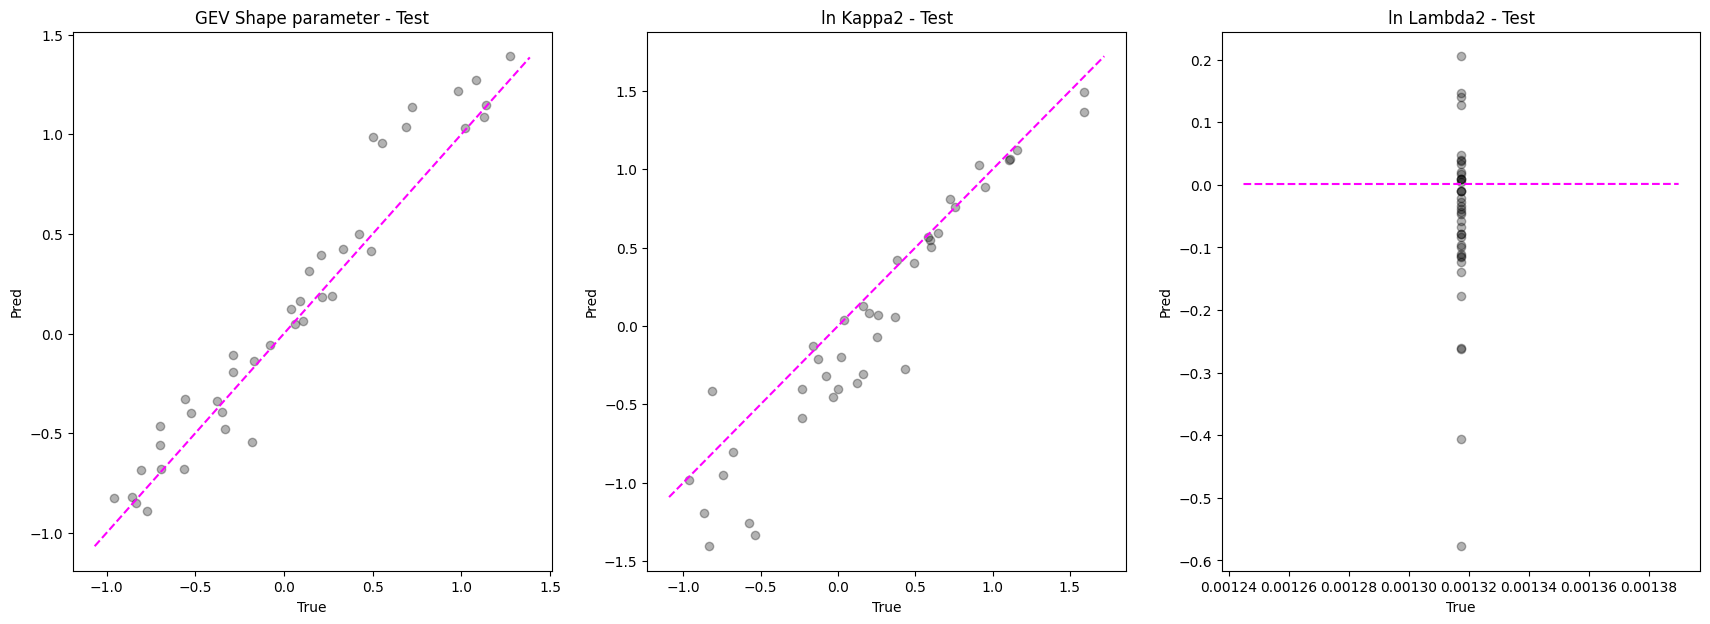

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_NGP[:,0]),
           (est_parameter_testRep[:, 10, 0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1]),
             (est_parameter_testRep[:, 10, 1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_NGP[:,2]),
            (est_parameter_testRep[:,10, 2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [ ]:
est_parameter_testRep.shape

(40, 1000, 3)

In [ ]:
# Assuming est_parameter_testRep has shape (1000, 60, 3)
shape_est_test = est_parameter_testRep[:, :, 0] * sd_shape + mean_shape
awght_est_test = est_parameter_testRep[:, :, 1] * sd_awght + mean_awght
lambda_est_test = est_parameter_testRep[:, :, 2] * sd_lambda + mean_lambda

# Stack them back along the last axis to maintain (1000, 60, 3)
est_parameter_testRep30 = np.stack((shape_est_test, awght_est_test, lambda_est_test), axis=-1)

print(est_parameter_testRep30.shape)

(40, 1000, 3)


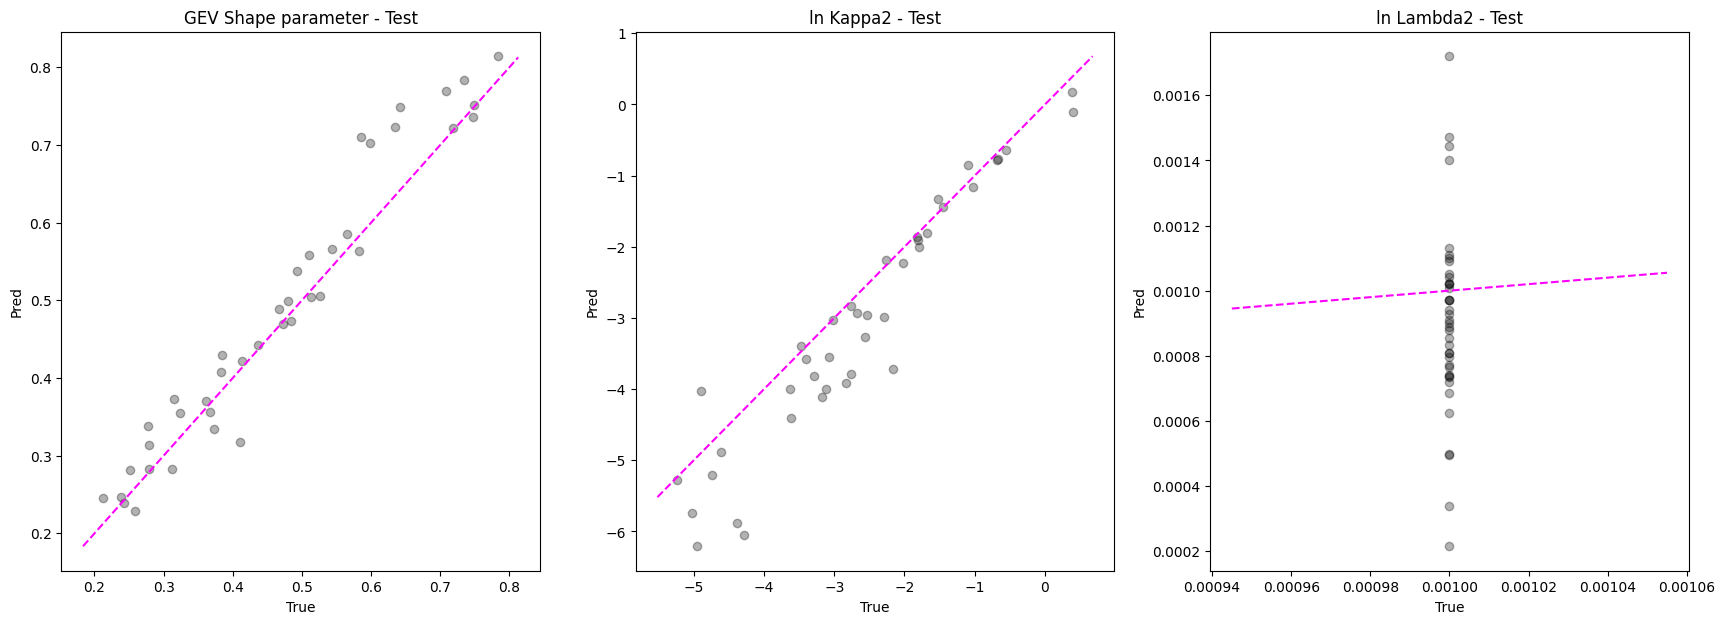

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_NGP[:,0])* sd_shape + mean_shape,
           (est_parameter_testRep30[:, 10, 0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_NGP[:,1])* sd_awght + mean_awght,
             (est_parameter_testRep30[:, 10, 1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(np.exp(Y_test_NGP[:,2]* sd_lambda + mean_lambda),
            np.exp(est_parameter_testRep30[:,10, 2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

0.4802003976888955
0.25075888754799963
0.7840911635663361


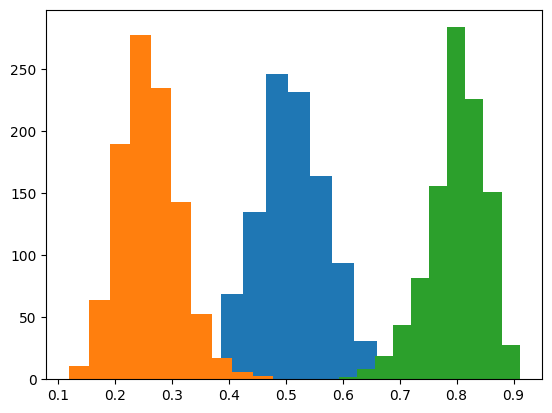

In [ ]:
plt.hist(shape_est_test[0,:])
print(Y_test_NGP[0,0]* sd_shape + mean_shape)

plt.hist(shape_est_test[1,:])
print(Y_test_NGP[1,0]* sd_shape + mean_shape)

plt.hist(shape_est_test[2,:])
print(Y_test_NGP[2,0]* sd_shape + mean_shape)

-1.8079678373707007
-1.0221739085198052
-3.1179749180679943


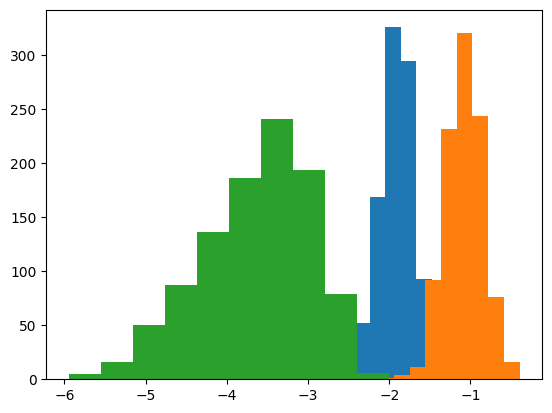

In [ ]:
plt.hist(awght_est_test[0,:])
print(Y_test_NGP[0, 1]* sd_awght + mean_awght)

plt.hist(awght_est_test[1,:])
print(Y_test_NGP[1, 1]* sd_awght + mean_awght)

plt.hist(awght_est_test[2,:])
print(Y_test_NGP[2, 1]* sd_awght + mean_awght)

In [ ]:
est_parameter_testRep30.shape

(40, 1000, 3)

In [ ]:
## Saving test data set across replication:
# np.save("est_para_testRep30_ML_smalls.npy", est_parameter_testRep30)
np.save("cnnEst-Cvg-fixedTau2-0.001.npy",  est_parameter_testRep30)

## ***Evaluate test set: for comparison with likelihood estimation***

In [ ]:
## Defining test set - Latest Jan 8, 2025
Parameter_read_ML_test = pyreadr.read_r('/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/MLE/TruePar-NoNugget-LikComp-01-28-25-Test.RData')

Parameter_read_ML_test = np.array(Parameter_read_ML_test['parameterComb'])
print('Dimension of the Parameter_data', Parameter_read_ML_test.shape)

Dimension of the Parameter_data (1024, 3)


In [ ]:
shape_vals_ML_test = (Parameter_read_ML_test[:,0])
awght_vals_ML_test = np.log(Parameter_read_ML_test[:,1]-4)
lambda_vals_ML_test = np.log(Parameter_read_ML_test[:,2])

In [ ]:
Y_test_ML = np.transpose(((shape_vals_ML_test - mean_shape)/sd_shape, (awght_vals_ML_test - mean_awght)/sd_awght, (lambda_vals_ML_test - mean_lambda)/sd_lambda))
print(Y_test_ML.shape)

(1024, 3)


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/MLE/storeZRep30-NoNugget-LikComp-01-28-25-Test.RData'

# storeZRep-Jan14-Test-Rep30-Latest.RData' # previously used file

r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'storeZRep' in the R environment
if 'extremalFields' in r_objects: # storeZRepScaled
    my_3d_array = r['extremalFields']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "extremalFields"

Shape of the array: (1024, 256, 30)


In [ ]:
import numpy as np
Z_test_ML_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
  if i % 1000 == 0:  # Correct modulus operator
        print(i)

  for j in range(numpy_3d_array.shape[2]):
    slice_mean = np.median(numpy_3d_array[i, :, j])
    slice_std = np.std(numpy_3d_array[i, :, j])

    if slice_std != 0:  #
        Z_test_ML_std[i, :, j] = (numpy_3d_array[i, :, j] - slice_mean)/slice_std
    else:
        Z_test_ML_std[i, :, j] = 0

0
1000


In [ ]:
Z_test_reshaped_ML = Z_test_ML_std.reshape(Z_test_ML_std.shape[0], 16, 16, 30) # (Z_test_NGP.shape[0], 100, 16, 16, 30)
Z_test_ML = np.array(Z_test_reshaped_ML)

# Print max and min values for the first sample in the reshaped array
print('Z_test max:', Z_test_ML[0,:,:].max())
print('Z_test min:', Z_test_ML[0,:,:].min())

Z_test_ML.shape

Z_test max: 1.961689276388946
Z_test min: -3.69634637746468


(1024, 16, 16, 30)

In [ ]:
test_estimates_ML = modelRep30.predict(Z_test_ML)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


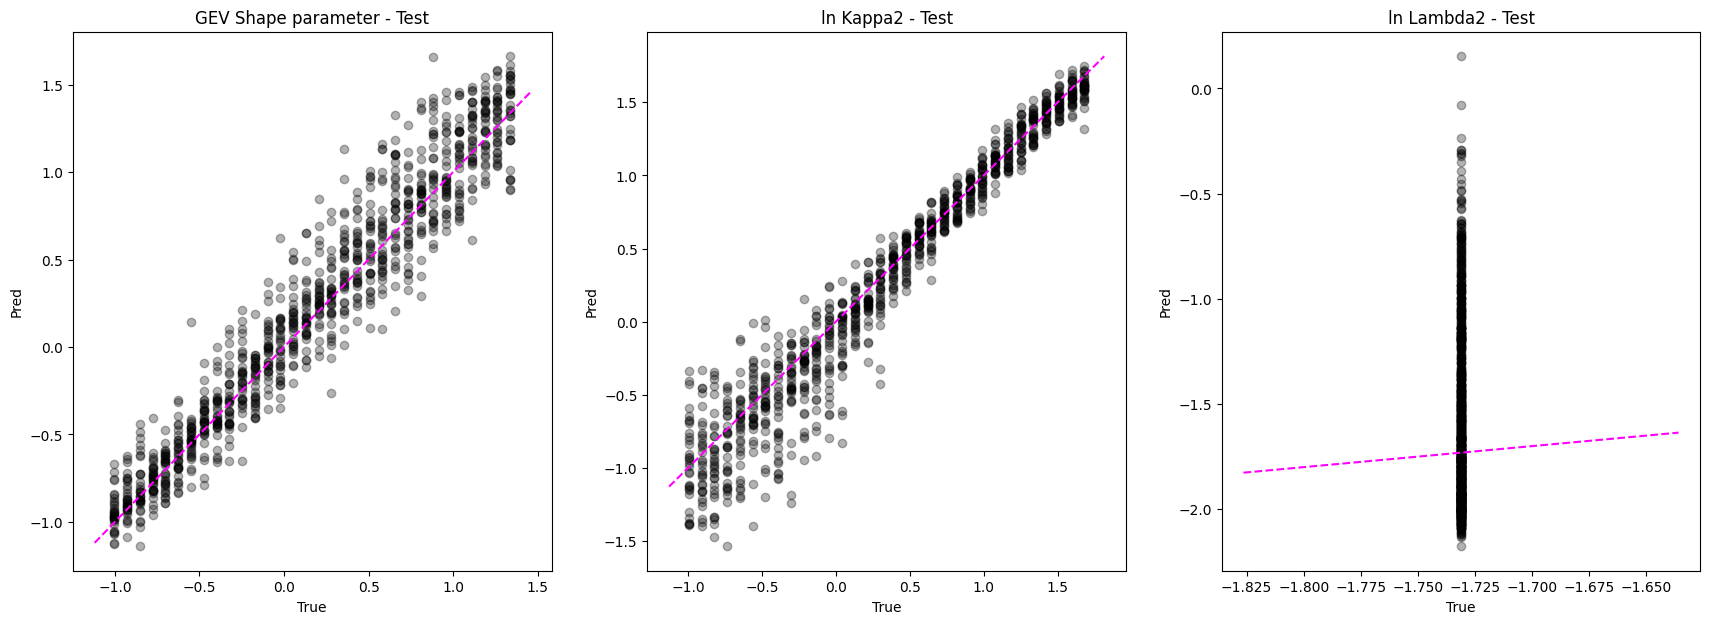

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_ML[:, 0]),
            (test_estimates_ML[:, 0]),
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_ML[:,1]),
            (test_estimates_ML[:,  1]),
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_ML[:,2]),
            (test_estimates_ML[:, 2]),
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [ ]:
import numpy as np

# Assuming test_estimates_ML has shape (1000, 60, 3)
shape_est_test = test_estimates_ML[:, 0] * sd_shape + mean_shape
awght_est_test = test_estimates_ML[:, 1] * sd_awght + mean_awght  # Removed comma
lambda_est_test = test_estimates_ML[:, 2] * sd_lambda + mean_lambda

# Stack along the last axis to maintain shape (1000, 60, 3)
est_parameter_testMLRep30 = np.stack([shape_est_test, awght_est_test, lambda_est_test], axis=-1)

# Check the shape
print("Final shape:", est_parameter_testMLRep30.shape)  # Should be (1000, 60, 3)

Final shape: (1024, 3)


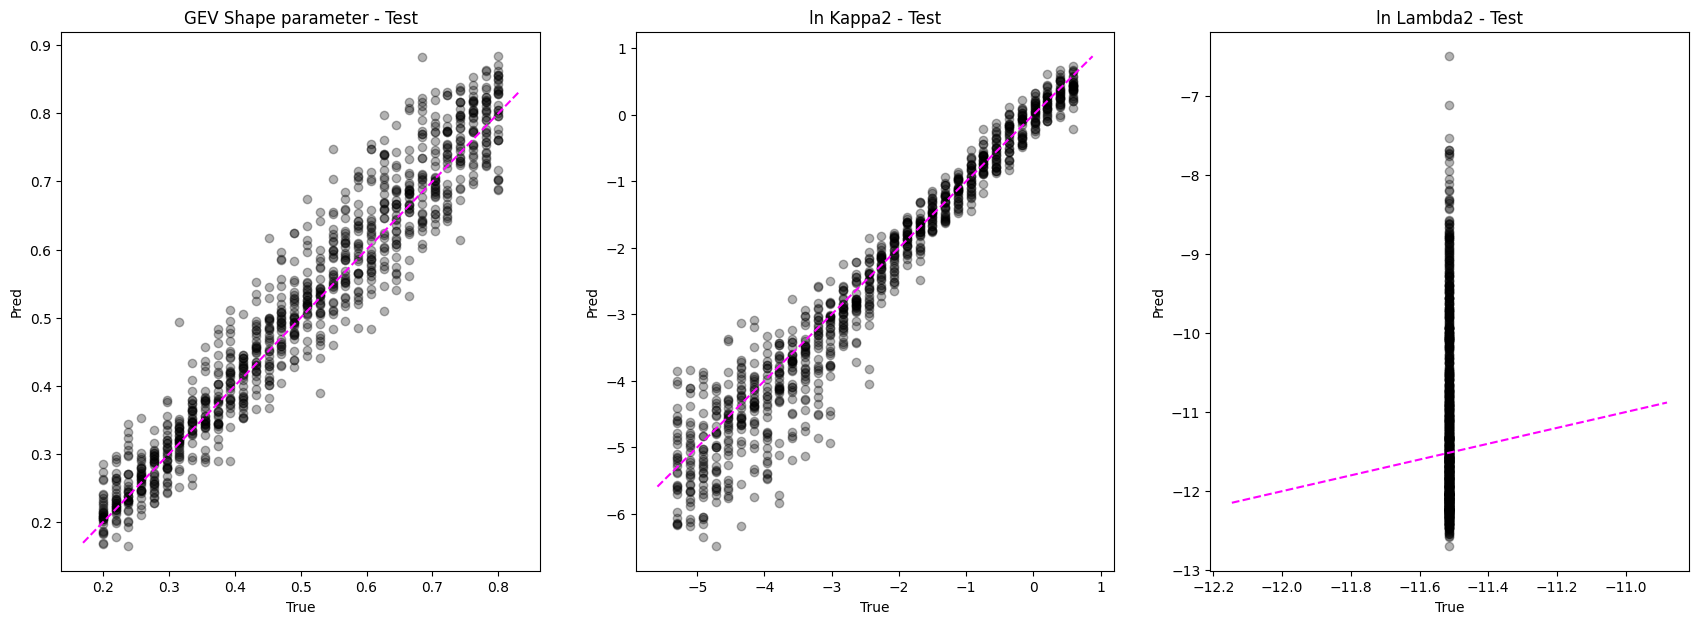

In [ ]:
plt.figure(figsize = (21,7))

plt.subplot(1,3,1)
plt.scatter((Y_test_ML[:,0]* sd_shape + mean_shape),
            est_parameter_testMLRep30[:,0],
            color = 'black',
            alpha=0.3)
plt.title('GEV Shape parameter - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,2)
plt.scatter((Y_test_ML[:,1]* sd_awght + mean_awght),
            est_parameter_testMLRep30[:,1],
            color = 'black',
            alpha=0.3)
plt.title('ln Kappa2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter((Y_test_ML[:,2]* sd_lambda + mean_lambda),
            est_parameter_testMLRep30[:,2],
            color = 'black',
            alpha=0.3)
plt.title('ln Lambda2 - Test')
plt.xlabel('True')
plt.ylabel('Pred')
abline(1, 0)

plt.show()

In [ ]:
est_parameter_testMLRep30.shape

(1024, 3)

In [ ]:
# Save the array to a .npy file
np.save('testEst-ML-n-30-Latest-01-28-25.npy', est_parameter_testMLRep30)

## ***RCM***

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import r
import numpy as np

# Load the RData file
rdata_file = '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/CaseStudy/RCMannualMax16x16-All.RData'
# RCMannualMax16x16-NoOverlaps.RData'
# '/content/drive/My Drive/Proj2-LKModel-ParameterEstimation-CNN/Store NGP Data/LatestStorage/16x16Grid/CaseStudy/RCMannualMax16x16gridObservations.RData'
# storeZRep-Jan14-Train-Rep30-Latest.RData'

r['load'](rdata_file)

# List the objects in the R environment after loading the file
r_objects = ro.r.ls()
print("Objects in the RData file:", r_objects)

# Assuming the 3D array is named 'storeZRep' in the R environment
if 'RCMannualMax16x16' in r_objects:
    my_3d_array = r['RCMannualMax16x16']

    # Convert the array to a NumPy array
    numpy_3d_array = np.array(my_3d_array)

    # Check the shape of the array
    print("Shape of the array:", numpy_3d_array.shape)
else:
    print("storeZRep not found in the RData file.")

Objects in the RData file: [1] "RCMannualMax16x16"

Shape of the array: (306, 16, 16, 30)


In [ ]:
import numpy as np
Z_test_RCM_std = np.empty_like(numpy_3d_array)

for i in range(numpy_3d_array.shape[0]):
  if i % 100 == 0:  # Correct modulus operator
        print(i)

  for j in range(numpy_3d_array.shape[2]):
    slice_mean = np.median(numpy_3d_array[i, :, j])
    slice_std = np.std(numpy_3d_array[i, :, j])

    # min = np.min(numpy_3d_array[i, :, j])
    # max = np.max(numpy_3d_array[i, :, j])

    if slice_std != 0:  #
        Z_test_RCM_std[i, :, j] = (numpy_3d_array[i, :, j] - slice_mean)/slice_std
    else:
        Z_test_RCM_std[i, :, j] = 0

0
100
200
300


In [ ]:
Z_test_RCM = Z_test_RCM_std.reshape(Z_test_RCM_std.shape[0], 16, 16, 30)

# Check the shape of the reshaped array
print('Shape of Z_test_reshaped:', Z_test_RCM.shape)

Z_test_RCM = np.array(Z_test_RCM)

# Print max and min values for the first sample in the reshaped array
print('Z_test_RCM max:',Z_test_RCM[0, :, :, :].max())
print('Z_test_RCM min:',Z_test_RCM[0, :, :, :].min())

Z_test_RCM.shape

Shape of Z_test_reshaped: (306, 16, 16, 30)
Z_test_RCM max: 8.09764538302559
Z_test_RCM min: -1.661691892049584


(306, 16, 16, 30)

In [ ]:
est_parameter_RCM = np.array(modelRep30.predict(Z_test_RCM))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
# Assuming est_parameter_testRep has shape (1000, 60, 3)
shape_est_test_RCM = est_parameter_RCM [:,0] * sd_shape + mean_shape
awght_est_test_RCM = est_parameter_RCM[:,  1] * sd_awght + mean_awght
lambda_est_test_RCM = est_parameter_RCM[:,  2] * sd_lambda + mean_lambda

# Stack them back along the last axis to maintain (1000, 60, 3)
est_parameter_test_RCM = np.stack((shape_est_test_RCM, awght_est_test_RCM, lambda_est_test_RCM), axis=-1)

print(est_parameter_test_RCM .shape)

(306, 3)


(array([ 5., 11., 29., 46., 52., 48., 43., 37., 27.,  8.]),
 array([0.24014373, 0.31701809, 0.39389244, 0.47076681, 0.54764116,
        0.62451553, 0.70138985, 0.77826422, 0.8551386 , 0.93201292,
        1.00888729]),
 <BarContainer object of 10 artists>)

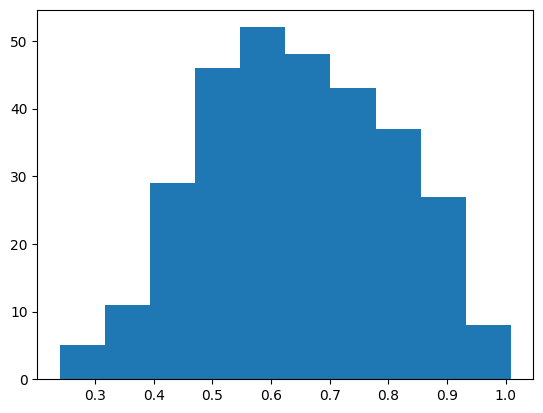

In [ ]:
plt.hist(est_parameter_test_RCM[:,0])

(array([245.,  43.,  11.,   2.,   2.,   0.,   2.,   0.,   0.,   1.]),
 array([ 4.01029444,  4.61761189,  5.22492933,  5.83224678,  6.43956423,
         7.04688168,  7.6541996 ,  8.26151657,  8.8688345 ,  9.47615147,
        10.08346939]),
 <BarContainer object of 10 artists>)

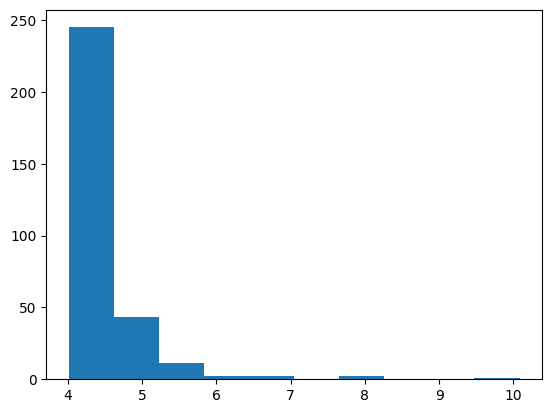

In [ ]:
plt.hist(np.exp(est_parameter_test_RCM[:,1])+4)

(array([212.,  59.,  22.,   7.,   1.,   2.,   2.,   0.,   0.,   1.]),
 array([2.10911722e-07, 2.44741095e-03, 4.89461143e-03, 7.34181143e-03,
        9.78901144e-03, 1.22362114e-02, 1.46834115e-02, 1.71306115e-02,
        1.95778124e-02, 2.20250115e-02, 2.44722124e-02]),
 <BarContainer object of 10 artists>)

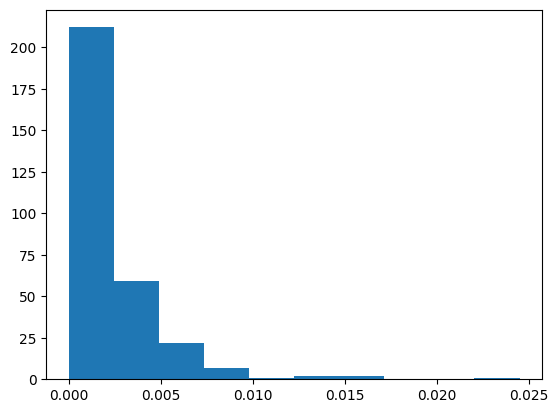

In [ ]:
plt.hist(np.exp(est_parameter_test_RCM[:,2]))

In [ ]:
np.save("est_parameter_test_RCM-All.npy",  est_parameter_test_RCM)